## <img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Part 3b - Modelling with SMOTE
- [Modelling with SMOTE](#Modelling-with-SMOTE)

## Import Libraries

In [3]:
# Basic imports
import pandas as pd
import numpy as np
from numpy import arange


# Time
import time
from datetime import datetime

# Visualisation 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import collections
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Data Processing 
import re
import string
import nltk


# Scikit-learn
from sklearn import ensemble, preprocessing
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline

# Vectorizing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Modelling - Basics
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV

# Modelling
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB

# Modelling - Classification metrics
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import plot_roc_curve, roc_auc_score

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', None)
pd.set_option('display.width', None)

## Load Data

In [4]:
df = pd.read_csv('../data/final_clean_df.csv')

In [5]:
df.head()

,vaers_id,age_yrs,sex,symptom_text,hospdays,recovd,numdays,v_adminby,other_meds,history,prior_vax,form_vers,er_ed_visit,allergies,vax_type,vax_manu,vax_dose_series,vax_route,vax_site,vax_name,serious,clean_symptom_text
0,916612.0,71.0,F,Left side of face became numb including to beh...,0.0,U,0.0,PVT,"levothyroxine 100mcg/day, estradiol 1mg/day",Graves Disease,NaN,2.0,0.0,"penicillin, toradol, methimazole",COVID19,MODERNA,0,IM,LA,COVID19 (COVID19 (MODERNA)),0,"['left', 'side', 'face', 'became', 'numb', 'in..."
1,916641.0,44.0,F,Vertigo every evening when lying down and ever...,0.0,N,0.0,PVT,"multivitamin, D3, baby aspirin",none,NaN,2.0,0.0,"latex, sulfa drugs",COVID19,MODERNA,0,IM,RA,COVID19 (COVID19 (MODERNA)),0,"['vertigo', 'every', 'evening', 'lying', 'ever..."
2,916702.0,70.0,F,body aches and stomach ache,0.0,N,31.0,PVT,Triamterene HCTZ Montelukast Celecoxib Aller-T...,asthma when I get a cold,NaN,2.0,0.0,too much cordosone,COVID19,MODERNA,0,SYR,UN,COVID19 (COVID19 (MODERNA)),0,"['body', 'ache', 'stomach', 'ache']"
3,917195.0,47.0,F,H a diarrhea SEVERE joint pain all through bo...,0.0,N,0.0,PVT,None,Serious episode of covid + 11/18/2020,NaN,2.0,0.0,None,COVID19,MODERNA,0,UN,RA,COVID19 (COVID19 (MODERNA)),0,"['h', 'diarrhea', 'severe', 'joint', 'pain', '..."
4,917195.0,47.0,F,H a diarrhea SEVERE joint pain all through bo...,0.0,N,0.0,PVT,None,Serious episode of covid + 11/18/2020,NaN,2.0,0.0,None,COVID19,MODERNA,0,UN,RA,COVID19 (COVID19 (MODERNA)),0,"['h', 'diarrhea', 'severe', 'joint', 'pain', '..."


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536690 entries, 0 to 536689
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   vaers_id            536690 non-null  float64
 1   age_yrs             536690 non-null  float64
 2   sex                 536690 non-null  object 
 3   symptom_text        536690 non-null  object 
 4   hospdays            536690 non-null  float64
 5   recovd              536690 non-null  object 
 6   numdays             536690 non-null  float64
 7   v_adminby           536690 non-null  object 
 8   other_meds          383513 non-null  object 
 9   history             380085 non-null  object 
 10  prior_vax           33754 non-null   object 
 11  form_vers           536690 non-null  float64
 12  er_ed_visit         536690 non-null  float64
 13  allergies           348819 non-null  object 
 14  vax_type            536690 non-null  object 
 15  vax_manu            536690 non-nul

### Splitting the Data

In [10]:
# Assign X & y
X = df['clean_symptom_text']
y = df['serious']

# Use test size of 90% as it represents around 50k rows of data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.9, 
                                                    random_state=200, stratify=y)

# Modelling with SMOTE

As our dataset is imbalanced with only 20% minority class (serious AE), we will try to use Synthetic Minority Oversampling Technique (SMOTE) to see if it yields better results.

#### Vectorization
* Count Vectorizer (CVEC)
* Term Frequency–Inverse Document Frequency Vectorizer (TFIDF)

#### Modelling
* Logistic Regression
* Naive Bayes - Multinomal
* Random Forest Classifier
* Ada Boost Classifier
* Support Vector Machine (SVM)

#### SMOTE
SMOTE is a technique of oversampling the minority class. This is achieved through the generation synthetic examples by drawing a line between examples in the minority class and drawing a new sample point along that line. This produces a more balanced dataset while not providing any additional external information to the model.

In [11]:
# Create empty results dataframe
df_results = pd.DataFrame(
    columns = [
        'Model No.',
        'Word Vectorizer',
        'Classifier',
        #'Cross-validated ROC AUC Score',
        'CV Score (train)',
        'Accuracy (train)',
        'Accuracy (test)',
        'Recall (test)', 
        'F1 score (test)',
        'Specificity (test)',
        'Precision (test)',
    ]
)

In [12]:
# Create function to run pipe and print results
def run_grid(X_train, X_test, y_train, y_test):

    
    # Instantiate GridSearchCV
    gs = GridSearchCV(
        pipe, 
        param_grid = params, 
        cv = 5,
        verbose = 1
    )

    # Fit model
    gs.fit(X_train, y_train)

    # Confusion matrix
    y_pred = gs.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    plot_confusion_matrix(gs, 
                  X_test, y_test, 
                  cmap='RdPu', 
                  values_format='d',
                  display_labels=['non-serious', 'serious']
                 );

    
    # Find current length of df_results
    length = len(df_results)
    
    # Store results in new_row
    new_row = [{
        'Model No.' : length + 1,
        'Word Vectorizer' : pipe.steps[0][1],
        'Classifier' : pipe.steps[2][1],
        #'Cross-validated ROC AUC Score' : round(gs.roc_auc_score(X_test, y_test), 3),
        'CV Score (train)' : round(gs.best_score_, 3),
        'Accuracy (train)': round(gs.score(X_train, y_train), 3),
        'Accuracy (test)' : round(gs.score(X_test, y_test), 3),
        'Recall (test)' : round (tp/(tp+fn), 3), 
        'F1 score (test)': round((tp/(tp+(fp+fn)/2)), 3),
        'Specificity (test)' : round (tn/(tn+fp), 3),
        'Precision (test)' : round (tp/(tp+fp), 3),
    }]
    
    # Print best parameters from GridSearchCV
    print('Best Parameters:', gs.best_params_)
    
    return new_row

### Logistic Regression

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'cvec__max_features': 20000, 'cvec__min_df': 10, 'cvec__ngram_range': (2, 2), 'logit__C': 10}
CPU times: user 11min 3s, sys: 1min 16s, total: 12min 19s
Wall time: 8min 41s


Text(0.5, 1.0, 'CVEC Logistic Regression')

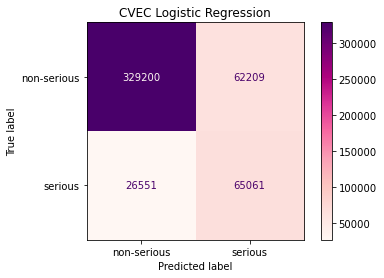

In [13]:
%%time

# Instantiate CountVectorizer() and LogisticRegressionCV()
cvec = CountVectorizer()
logit = LogisticRegression()

pipe = imbpipeline(steps = [['cvec', cvec],
                            ['smote', SMOTE(random_state=200)],
                            ['logit', logit]])



params = {
    'cvec__max_features': [5000, 10000, 20000],
    'cvec__ngram_range': [(2,2)], 
    'cvec__min_df': [10],
    #'cvec__ngram_range': [(1,1), (1,2), (1,3)],     
    'logit__C': [0.1, 1, 10],} 
    #'logit__penalty': ['l1', 'l2', 'none']}


new_results = run_grid(X_train, X_test, y_train, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
plt.title('CVEC Logistic Regression');

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'logit__C': 10, 'tvec__max_features': 20000, 'tvec__min_df': 10, 'tvec__ngram_range': (2, 2)}
CPU times: user 10min 1s, sys: 1min 6s, total: 11min 8s
Wall time: 7min 59s


Text(0.5, 1.0, 'TVEC Logistic Regression')

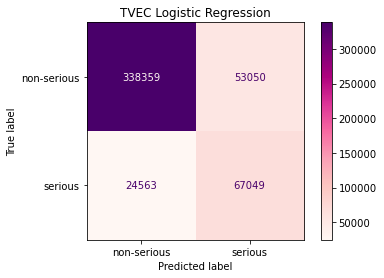

In [14]:
%%time

# Instantiate TfidfVectorizer() and LogisticRegressionCV()
tvec = TfidfVectorizer()
logit = LogisticRegression()

pipe = imbpipeline(steps = [['tvec', tvec],
                            ['smote', SMOTE(random_state=200)],
                            ['logit', logit]])

params = {
    'tvec__max_features': [5000, 10000, 20000],
    'tvec__ngram_range': [(2,2)],
    'tvec__min_df': [10],
    #'tvec__ngram_range': [(1,1), (1,2), (1,3)],    
    'logit__C': [0.1, 1, 10],} 
    #'logit__penalty': ['l1', 'l2', 'none']}


new_results = run_grid(X_train, X_test, y_train, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
plt.title('TVEC Logistic Regression');

In [15]:
df_results

,Model No.,Word Vectorizer,Classifier,CV Score (train),Accuracy (train),Accuracy (test),Recall (test),F1 score (test),Specificity (test),Precision (test)
0,1,CountVectorizer(),LogisticRegression(),0.815,0.938,0.816,0.710,0.594,0.841,0.511
0,2,TfidfVectorizer(),LogisticRegression(),0.837,0.933,0.839,0.732,0.633,0.864,0.558


**Observations:**

The model has hit our target of 0.7 for accuracy but not the F1 score which should also be 0.7.

The model has a decent train accuracy score of > 0.9 and test accuracy score of > 0.8, with F1 score below our target of 0.7. Recall at 0.7 does mean that SMOTE is helping to better classify serious AE, however it seems to be misclassifying non-serious AE with precision at 0.5.

### Multinomial Naive Bayes

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'cvec__max_features': 40000, 'cvec__min_df': 10, 'cvec__ngram_range': (2, 2), 'nb__alpha': 0.5, 'nb__fit_prior': True}
CPU times: user 8min 20s, sys: 25.7 s, total: 8min 46s
Wall time: 8min 50s


Text(0.5, 1.0, 'CVEC Naive Bayes')

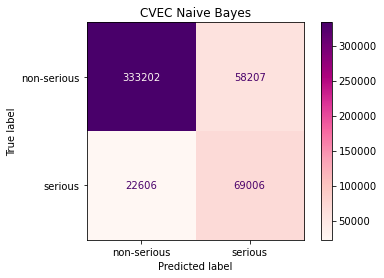

In [16]:
%%time

# Instantiate CountVectorizer() and MultinomialNB()
cvec = CountVectorizer()
nb = MultinomialNB()

pipe = imbpipeline(steps = [['cvec', cvec],
                            ['smote', SMOTE(random_state=200)],
                            ['nb', nb]])

params = {
    'cvec__max_features': [10000, 20000, 40000],
    'cvec__ngram_range': [(2,2)], 
    'cvec__min_df': [10],
    'nb__alpha': np.linspace(0.5, 1.5, 2),
    'nb__fit_prior': [True, False]
}

new_results = run_grid(X_train, X_test, y_train, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
plt.title('CVEC Naive Bayes');

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'nb__alpha': 0.5, 'nb__fit_prior': True, 'tvec__max_features': 40000, 'tvec__min_df': 10, 'tvec__ngram_range': (2, 2)}
CPU times: user 8min 3s, sys: 24 s, total: 8min 26s
Wall time: 8min 29s


Text(0.5, 1.0, 'TF-IDF Naive Bayes')

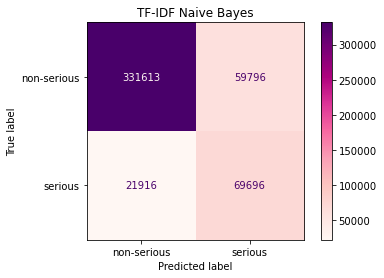

In [17]:
%%time

# Instantiate TfidfVectorizer() and MultinomialNB()
tvec = TfidfVectorizer()
nb = MultinomialNB()

pipe = imbpipeline(steps = [['tvec', tvec],
                            ['smote', SMOTE(random_state=200)],
                            ['nb', nb]])

params = {
    'tvec__max_features': [10000, 20000, 40000],
    'tvec__ngram_range': [(2,2)], 
    'tvec__min_df': [10],
    'nb__alpha': np.linspace(0.5, 1.5, 2),
    'nb__fit_prior': [True, False]}

new_results = run_grid(X_train, X_test, y_train, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
plt.title('TF-IDF Naive Bayes');

In [18]:
df_results

,Model No.,Word Vectorizer,Classifier,CV Score (train),Accuracy (train),Accuracy (test),Recall (test),F1 score (test),Specificity (test),Precision (test)
0,1,CountVectorizer(),LogisticRegression(),0.815,0.938,0.816,0.710,0.594,0.841,0.511
0,2,TfidfVectorizer(),LogisticRegression(),0.837,0.933,0.839,0.732,0.633,0.864,0.558
0,3,CountVectorizer(),MultinomialNB(),0.826,0.854,0.833,0.753,0.631,0.851,0.542
0,4,TfidfVectorizer(),MultinomialNB(),0.829,0.860,0.831,0.761,0.630,0.847,0.538


**Observations:**

Multinomial Naive Bayes has hit our target of 0.7 for accuracy but not the F1 score which should also be 0.7.

With a train and test accuracy score of 0.8 indicating good accuracy, the F1 score of 0.6 indicates that the model is still misclassifying both serious and non-serious AE. Recall at 0.7 does mean that SMOTE is helping to better classify serious AE, however it seems to be misclassifying non-serious AE with precision at 0.5.

### Random Forest Classifier

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {'cvec__max_features': 5000, 'cvec__min_df': 10, 'cvec__ngram_range': (2, 2)}
CPU times: user 20min 38s, sys: 9.12 s, total: 20min 47s
Wall time: 20min 55s


Text(0.5, 1.0, 'CVEC and Random Forest Classifier')

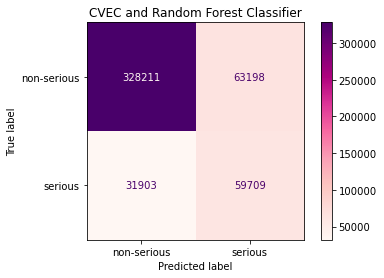

In [19]:
%%time

# Instantiate CountVectorizer() and RandomForestClassifier()
cvec = CountVectorizer()
rfc = RandomForestClassifier()

pipe = imbpipeline(steps = [['cvec', cvec],
                            ['smote', SMOTE(random_state=200)],
                            ['rfc', rfc]])

params = {
    'cvec__max_features': [5000],
    'cvec__ngram_range': [(2,2)], 
    'cvec__min_df': [10],}  
    #'rfc__n_estimators': [10, 100, 500]} 

new_results = run_grid(X_train, X_test, y_train, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
plt.title('CVEC and Random Forest Classifier');

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {'tvec__max_features': 5000, 'tvec__min_df': 10, 'tvec__ngram_range': (2, 2)}
CPU times: user 19min 17s, sys: 8.71 s, total: 19min 26s
Wall time: 19min 34s


Text(0.5, 1.0, 'TVEC and Random Forest Classifier')

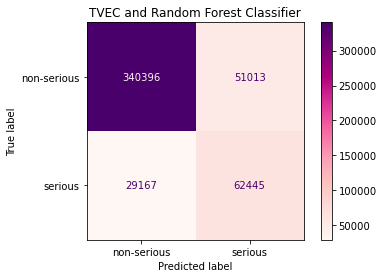

In [20]:
%%time

# Instantiate TfidfVectorizer() and RandomForestClassifier()
tvec = TfidfVectorizer()
rfc = RandomForestClassifier()

pipe = imbpipeline(steps = [['tvec', tvec],
                            ['smote', SMOTE(random_state=200)],
                            ['rfc', rfc]])

params = {
    'tvec__max_features': [5000],
    'tvec__ngram_range': [(2,2)], 
    'tvec__min_df': [10],}
    #'tvec__ngram_range': [(1,1), (1,2), (1,3)],    
    #'rfc__n_estimators': [10, 100, 500],} 

new_results = run_grid(X_train, X_test, y_train, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
plt.title('TVEC and Random Forest Classifier');

In [21]:
df_results

,Model No.,Word Vectorizer,Classifier,CV Score (train),Accuracy (train),Accuracy (test),Recall (test),F1 score (test),Specificity (test),Precision (test)
0,1,CountVectorizer(),LogisticRegression(),0.815,0.938,0.816,0.710,0.594,0.841,0.511
0,2,TfidfVectorizer(),LogisticRegression(),0.837,0.933,0.839,0.732,0.633,0.864,0.558
0,3,CountVectorizer(),MultinomialNB(),0.826,0.854,0.833,0.753,0.631,0.851,0.542
0,4,TfidfVectorizer(),MultinomialNB(),0.829,0.860,0.831,0.761,0.630,0.847,0.538
0,5,CountVectorizer(),RandomForestClassifier(),0.797,0.952,0.803,0.652,0.557,0.839,0.486
0,6,TfidfVectorizer(),RandomForestClassifier(),0.829,0.963,0.834,0.682,0.609,0.870,0.550


**Observations:**

Random Forest Classifier has hit our target of 0.7 for accuracy but not the F1 score which should also be 0.7.

With a score train accuracy score of > 0.9 and test accuracy score of > 0.8, it indicates that the model is able to correctly predict serious AE 90% in the train dataset and 80% in the test dataset. With the highest train accuracy out of all the models thus far, it suggests that the rfc is highly fitted to the train model. As seen from  the difference between the train and test accuracy being the greatest so far, it seems that the model is highly overfitted to the train data as compared to the prior models. We also find the tvec with a higher test accuracy score, indicating it is less overfitted as compared to the model using cvec as a vectorizer.

It has the lowest F1 score of 0.5-0.6 amongst the SMOTE-ed models thus far, indicating a higher propensity to misclassify both serious and non-serious AE.

### Ada Boost Classifier

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {'cvec__max_features': 5000, 'cvec__min_df': 10, 'cvec__ngram_range': (2, 2)}
CPU times: user 2min 37s, sys: 3.95 s, total: 2min 41s
Wall time: 2min 42s


Text(0.5, 1.0, 'CVEC and Ada Boost Classifier')

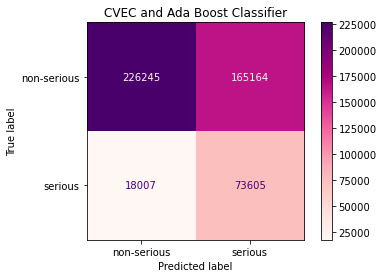

In [22]:
%%time

# Instantiate CountVectorizer() and AdaBoostClassifier()
cvec = CountVectorizer()
ada = AdaBoostClassifier()

pipe = imbpipeline(steps = [['cvec', cvec],
                            ['smote', SMOTE(random_state=200)],
                            ['ada', ada]])

params = {
    'cvec__max_features': [5000],
    'cvec__ngram_range': [(2,2)], 
    'cvec__min_df': [10]}  

new_results = run_grid(X_train, X_test, y_train, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
plt.title('CVEC and Ada Boost Classifier');

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {'tvec__max_features': 5000, 'tvec__min_df': 10, 'tvec__ngram_range': (2, 2)}
CPU times: user 3min 17s, sys: 4.81 s, total: 3min 22s
Wall time: 3min 24s


Text(0.5, 1.0, 'TVEC and Ada Boost Classifier')

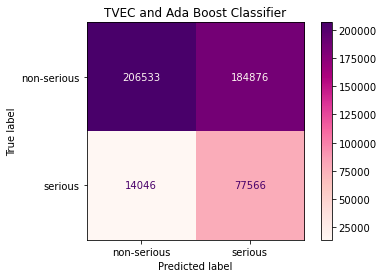

In [23]:
%%time

# Instantiate TfidfVectorizer() and AdaBoostClassifier()
tvec = TfidfVectorizer() 
ada = AdaBoostClassifier()

pipe = imbpipeline(steps = [['tvec', tvec],
                            ['smote', SMOTE(random_state=200)],
                            ['ada', ada]])

params = {
    'tvec__max_features': [5000],
    'tvec__ngram_range': [(2,2)], 
    'tvec__min_df': [10]}  

new_results = run_grid(X_train, X_test, y_train, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
plt.title('TVEC and Ada Boost Classifier');

In [24]:
df_results

,Model No.,Word Vectorizer,Classifier,CV Score (train),Accuracy (train),Accuracy (test),Recall (test),F1 score (test),Specificity (test),Precision (test)
0,1,CountVectorizer(),LogisticRegression(),0.815,0.938,0.816,0.710,0.594,0.841,0.511
0,2,TfidfVectorizer(),LogisticRegression(),0.837,0.933,0.839,0.732,0.633,0.864,0.558
0,3,CountVectorizer(),MultinomialNB(),0.826,0.854,0.833,0.753,0.631,0.851,0.542
0,4,TfidfVectorizer(),MultinomialNB(),0.829,0.860,0.831,0.761,0.630,0.847,0.538
0,5,CountVectorizer(),RandomForestClassifier(),0.797,0.952,0.803,0.652,0.557,0.839,0.486
0,6,TfidfVectorizer(),RandomForestClassifier(),0.829,0.963,0.834,0.682,0.609,0.870,0.550
0,7,CountVectorizer(),AdaBoostClassifier(),0.616,0.624,0.621,0.803,0.446,0.578,0.308
0,8,TfidfVectorizer(),AdaBoostClassifier(),0.584,0.594,0.588,0.847,0.438,0.528,0.296


**Observations:**

Ada Boost Classifer has not met either target of 0.7 for both accuracy and F1 score.

With the lowest train and test accuracy at 0.5-0.6, it indicates the model is not predicting serious and non-serious AE accurately. The model also produces a low F1 score of 0.4, with a surprisingly high recall of 0.8 and dismal precision of 0.2-0.3. This suggests that it is more likely to misclassify non-serious as serious, leading to an over-reporting of serious AE.

### Support Vector Machines (SVM)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'cvec__max_features': 5000, 'cvec__min_df': 10, 'cvec__ngram_range': (2, 2), 'svc__C': 10, 'svc__degree': 2, 'svc__kernel': 'poly'}
CPU times: user 10h 32min 33s, sys: 2min 25s, total: 10h 34min 59s
Wall time: 10h 39min 52s


Text(0.5, 1.0, 'CVEC and SVC')

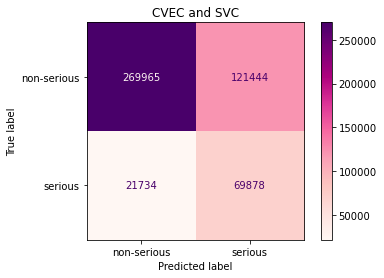

In [25]:
%%time

# Instantiate CountVectorizer() and SVC()
cvec = CountVectorizer()
svc = SVC()

pipe = imbpipeline(steps = [['cvec', cvec],
                            ['smote', SMOTE(random_state=200)],
                            ['svc', svc]])

params = {
    'cvec__max_features': [5000, 10000, 20000],
    'cvec__ngram_range': [(2,2)],
    'cvec__min_df': [10],
    #'tvec__ngram_range': [(1,1), (1,2), (1,3)],    
    'svc__C': [0.1, 1, 10], 
    'svc__kernel': ['poly'], 
    'svc__degree': [2]}



new_results = run_grid(X_train, X_test, y_train, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
plt.title('CVEC and SVC');

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'svc__C': 1, 'svc__degree': 2, 'svc__kernel': 'poly', 'tvec__max_features': 10000, 'tvec__min_df': 10, 'tvec__ngram_range': (2, 2)}
CPU times: user 16h 11min 13s, sys: 2min 10s, total: 16h 13min 24s
Wall time: 16h 15min 2s


Text(0.5, 1.0, 'TVEC and SVC')

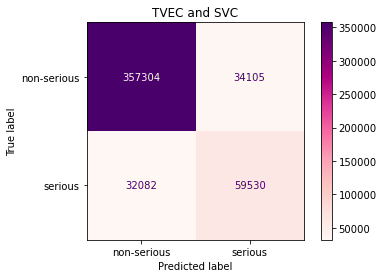

In [26]:
%%time

# Instantiate TfidfVectorizer() and SVC()
tvec = TfidfVectorizer()
svc = SVC()

pipe = imbpipeline(steps = [['tvec', tvec],
                            ['smote', SMOTE(random_state=200)],
                            ['svc', svc]])

params = {
    'tvec__max_features': [5000, 10000, 20000],
    'tvec__ngram_range': [(2,2)], 
    'tvec__min_df': [10],
    #'tvec__ngram_range': [(1,1), (1,2), (1,3)],    
    'svc__C': [0.1, 1, 10], 
    'svc__kernel': ['poly'], 
    'svc__degree': [2]}


new_results = run_grid(X_train, X_test, y_train, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
plt.title('TVEC and SVC');

In [27]:
df_results

,Model No.,Word Vectorizer,Classifier,CV Score (train),Accuracy (train),Accuracy (test),Recall (test),F1 score (test),Specificity (test),Precision (test)
0,1,CountVectorizer(),LogisticRegression(),0.815,0.938,0.816,0.710,0.594,0.841,0.511
0,2,TfidfVectorizer(),LogisticRegression(),0.837,0.933,0.839,0.732,0.633,0.864,0.558
0,3,CountVectorizer(),MultinomialNB(),0.826,0.854,0.833,0.753,0.631,0.851,0.542
0,4,TfidfVectorizer(),MultinomialNB(),0.829,0.860,0.831,0.761,0.630,0.847,0.538
0,5,CountVectorizer(),RandomForestClassifier(),0.797,0.952,0.803,0.652,0.557,0.839,0.486
0,6,TfidfVectorizer(),RandomForestClassifier(),0.829,0.963,0.834,0.682,0.609,0.870,0.550
0,7,CountVectorizer(),AdaBoostClassifier(),0.616,0.624,0.621,0.803,0.446,0.578,0.308
0,8,TfidfVectorizer(),AdaBoostClassifier(),0.584,0.594,0.588,0.847,0.438,0.528,0.296
0,9,CountVectorizer(),SVC(),0.694,0.799,0.704,0.763,0.494,0.690,0.365
0,10,TfidfVectorizer(),SVC(),0.855,0.971,0.863,0.650,0.643,0.913,0.636


**Observations:**

SVM has met the accuracy target score of 0.7 but not the F1 score of 0.7.

With the both accuracy score around 0.7-0.8 for cvec and 0.8-0.9 for tvec, the model is able to predict serious AE correctly relatively well. However, with a F1 score of 0.5 for cvec and 0.6 for tvec, the tvec model seems to be performing than our other models using SMOTE so far.

#### Final thoughts on modelling with SMOTE:
SVC with TF-IDF vectorizer has the most balanced performance with a train accuracy of 0.971, test accuracy of 0.863 and F1 score of 0.643. But, we find the Logistic Regression with TF-IDF without SMOTE still outperforms this model.

Modelling with SMOTE does not seem to yield better results as compared to using the mildly imbalanced dataset. A possible reason for this is that while oversampling our minority class, this may have led to overfitting of the model which is seen in the greater difference between the train and test accuracy scores as compared to our first round of modelling. Another reason is that our minority class makes up around 20% of our dataset, and by taking 90% of the data as the train dataset we still get 10k rows of serious AE, which may be a large enough sample size for the model to train on, hence not requiring imbalance dataset techniques to improve metric scores.


For our next iteration, we will try 80% of our data as the training set.